# IMAGE CLASSIFICATION

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.5
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)

## Import Libraries 

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load 

In [3]:
# Paths

test_dir = 'G:\\Arun\\DS23\\DS\\project4\\dataset\\test_set'
train_dir = 'G:\\Arun\\DS23\\DS\\project4\\dataset\\training_set'


In [4]:
# Hyperparameters
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (299,299),
    epochs = 5,
    patience = 5
)

## Data augmentation 

In [5]:
# Augment train set only
train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data

In [6]:
# Connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 6800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Classes:['cats', 'dogs']


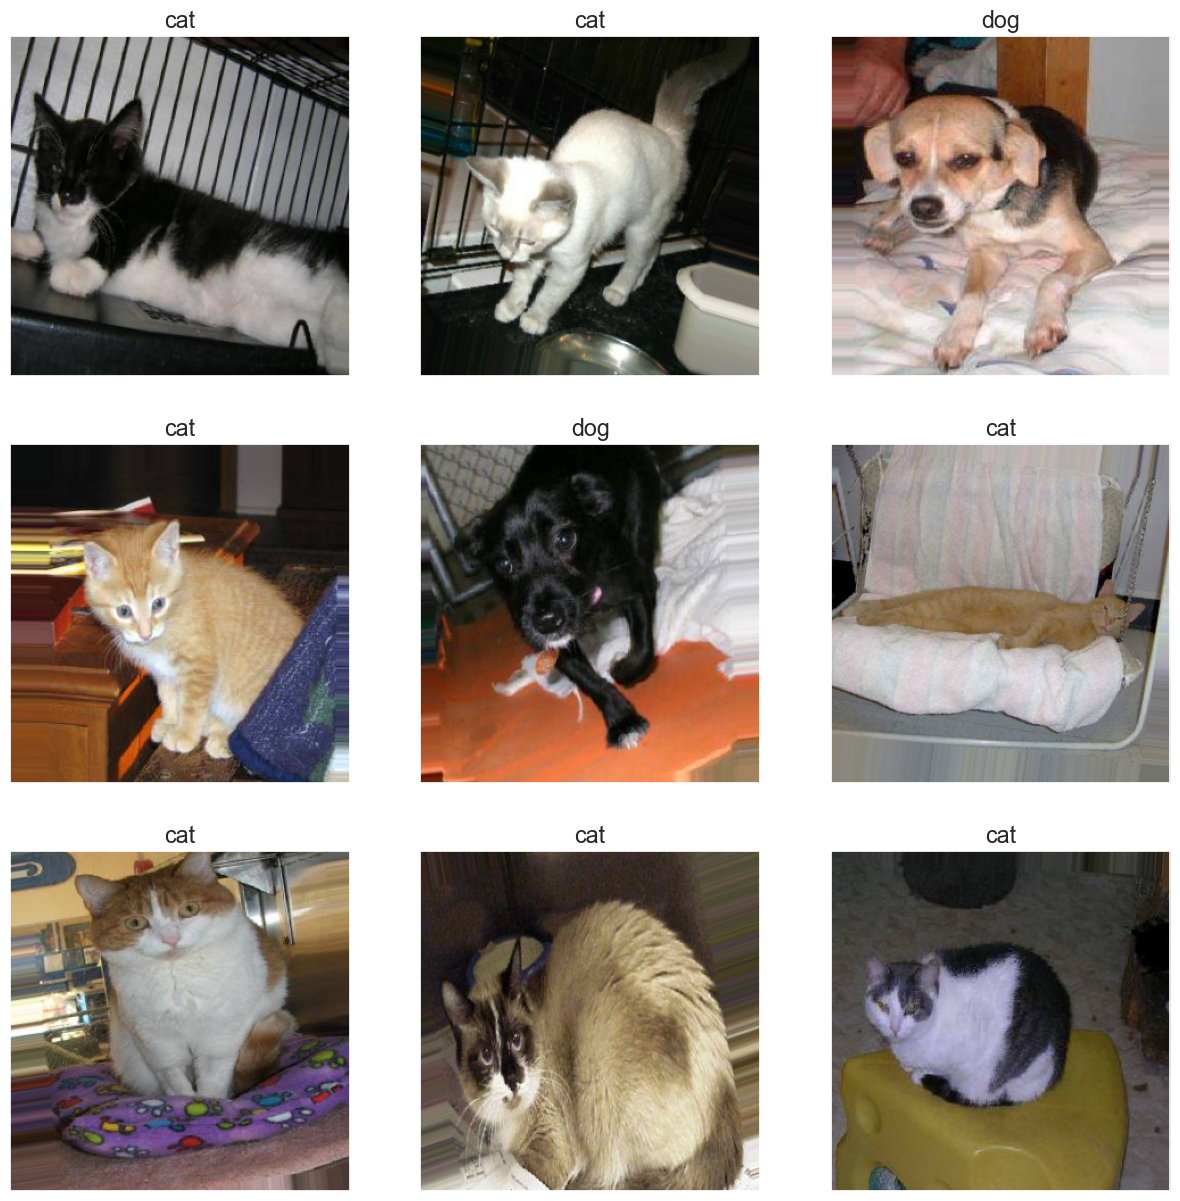

In [7]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()


# Transfer Learning

In [9]:
# building CNN
model = keras.Sequential([
    # Conv layer 1:
    keras.layers.Conv2D(128, (3, 3), input_shape=(64,64,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 2:
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    # Conv layer 3:
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    
    keras.layers.Flatten(),
    
    # fully connected layers:
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dense(units =1, activation = 'sigmoid')
    
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics ='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

# Transfer Learning

In [10]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 60s 0us/step


In [11]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

# Train model

In [14]:
#Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/5
425/425 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9809 
Epoch 1: val_loss improved from inf to 0.01616, saving model to model.h5
425/425 [==============================] - 6989s 16s/step - loss: 0.1136 - accuracy: 0.9809 - val_loss: 0.0162 - val_accuracy: 0.9933
Epoch 2/5
425/425 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9928 
Epoch 2: val_loss did not improve from 0.01616
425/425 [==============================] - 6888s 16s/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0180 - val_accuracy: 0.9933
Epoch 3/5
425/425 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9910 
Epoch 3: val_loss improved from 0.01616 to 0.01343, saving model to model.h5
425/425 [==============================] - 6769s 16s/step - loss: 0.0261 - accuracy: 0.9910 - val_loss: 0.0134 - val_accuracy: 0.9975
Epoch 4/5
425/425 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9913 
Epoch 4: val_loss

# Loss and Accuracy learning curves 

In [15]:
# History
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

Text(0, 0.5, 'Loss')

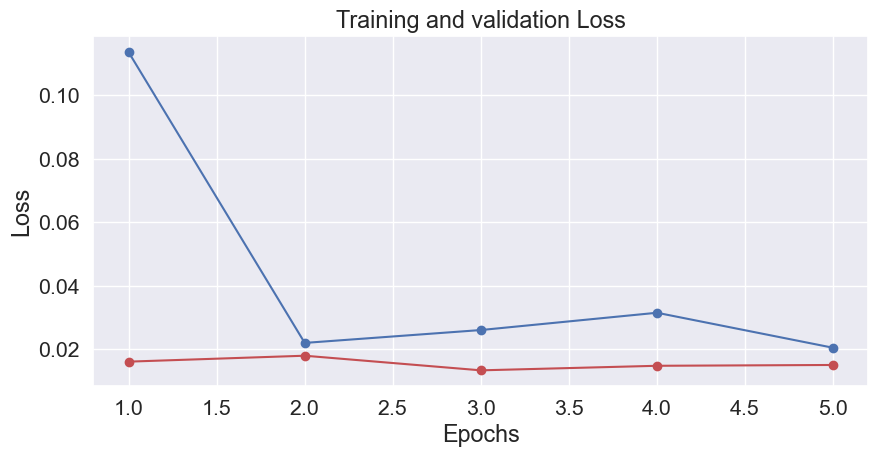

In [16]:
# Loss
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

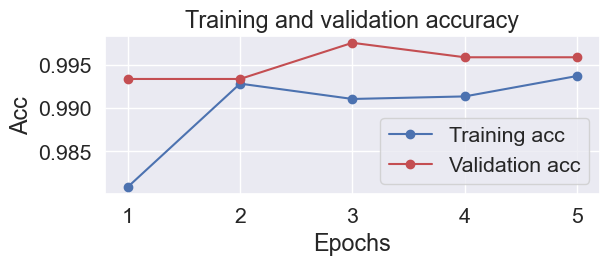

In [17]:
# Accuracy
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation 

In [18]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.015115739777684212
Val accuracy: 0.9958333373069763


In [19]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025990059599280357
Test accuracy: 0.9950000047683716


125/125 [==============================] - 1711s 14s/step


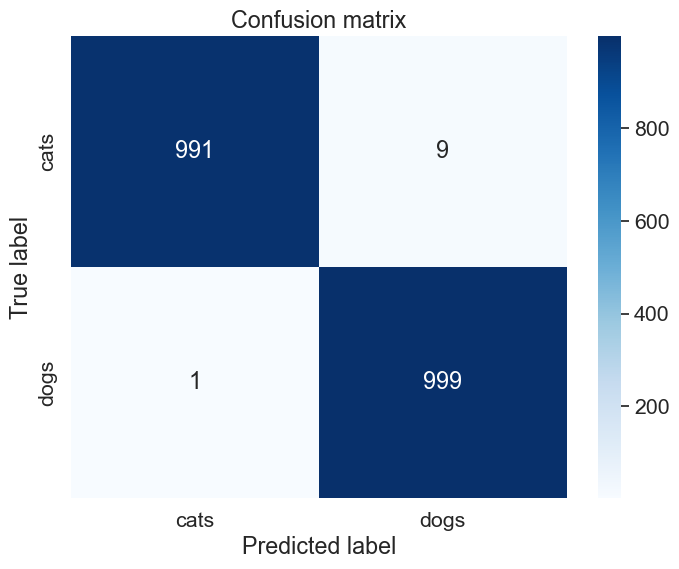

In [22]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()